## Load models
We are using a deep closed model (BP105) and a deep deprotinated model (BP106) both trained using BPbi (BPcm_250 based) architecture

In [1]:
from load_model import load_data, load_model, get_predictions
from eval_model import get_model_structure

def load_bias_model(saved_model_path):
    model_type = 'BPbi'
    n_filters=300
    n_celltypes=1
    seq_len=1000

    model_structure = get_model_structure(model_type, n_filters, n_celltypes, seq_len=seq_len)
    model = load_model(saved_model_path, model_structure=model_structure)
    return model

deprot_model_path = # TODO insert your model path
deprot_model = load_bias_model(deprot_model_path)
closed_model_path = # TODO insert your model path
closed_model = load_bias_model(closed_model_path)




Selected GPU: 0
DEVICE is cuda:0
200
40
8
DEVICE is cuda:0
998 64 90
MODEL STRUCTURE BPbi(
  (body): Body(
    (net): Sequential(
      (0): Conv1d(4, 300, kernel_size=(25,), stride=(1,), padding=same)
      (1): DialatedConvs(
        (net): Sequential(
          (0): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
              (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (1): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilation=(4,))
              (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (2): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride

## Get model performance on deprotinated DNA data

In [2]:
from utils import load_data_non_memmaped

def get_profile_preds(data_config, model, model_dir, saved_file_name, data_non_memmaped = True):
    eval_set = 'validation'
    n_celltypes = 1
    bin_size = 1
    ocr_start = 0
    ocr_end = 250
    get_scalar_prediction, get_profile_prediction, get_scalar_observed, get_profile_observed = True, True, True, True
    seq_len = 250

    if data_non_memmaped:
        train_loader, val_loader, test_loader = load_data_non_memmaped(data_config, batch_size=100)
    else:
        train_loader, val_loader, test_loader = load_data(data_config, batch_size=100)
    
    scalar_obs, scalar_pred, profile_obs, profile_pred = get_predictions(model, train_loader, val_loader, test_loader, 
                    n_celltypes, 
                    get_scalar_prediction, get_profile_prediction,
                    get_scalar_observed, get_profile_observed,
                    eval_set,
                    bin_size,
                    model_dir,
                    saved_file_name = saved_file_name, 
                    batch_size=100, 
                    save_pred=True,
                    ocr_start=ocr_start, ocr_end=ocr_end,
                    seq_len=seq_len)
    return profile_pred, profile_obs

In [59]:
from utils import load_data_non_memmaped
import os


deprotinated_config = # TODO insert your path to 'bias_config.yaml'
deprot_deprot_profile_pred, deprot_obs = get_profile_preds(deprotinated_config, model=deprot_model, model_dir=os.path.dirname(deprot_model_path), saved_file_name='predictions_on_deprotinated_dna_val.npz')

USING validation data loader
batch num 0
bias shape before it goes into model torch.Size([100, 250])
batch num 1
bias shape before it goes into model torch.Size([100, 250])
batch num 2
bias shape before it goes into model torch.Size([100, 250])
batch num 3
bias shape before it goes into model torch.Size([100, 250])
batch num 4
bias shape before it goes into model torch.Size([100, 250])
batch num 5
bias shape before it goes into model torch.Size([100, 250])
batch num 6
bias shape before it goes into model torch.Size([100, 250])
batch num 7
bias shape before it goes into model torch.Size([100, 250])
batch num 8
bias shape before it goes into model torch.Size([100, 250])
batch num 9
bias shape before it goes into model torch.Size([100, 250])
batch num 10
bias shape before it goes into model torch.Size([100, 250])
batch num 11
bias shape before it goes into model torch.Size([100, 250])
batch num 12
bias shape before it goes into model torch.Size([100, 250])
batch num 13
bias shape before i

In [60]:
closed_model_deprot_profile_pred, deprot_profile_obs_2 = get_profile_preds(deprotinated_config, model=closed_model, model_dir=os.path.dirname(closed_model_path), saved_file_name='predictions_on_deprotinated_dna_val_correct.npz')

USING validation data loader
batch num 0
bias shape before it goes into model torch.Size([100, 250])
batch num 1
bias shape before it goes into model torch.Size([100, 250])
batch num 2
bias shape before it goes into model torch.Size([100, 250])
batch num 3
bias shape before it goes into model torch.Size([100, 250])
batch num 4
bias shape before it goes into model torch.Size([100, 250])
batch num 5
bias shape before it goes into model torch.Size([100, 250])
batch num 6
bias shape before it goes into model torch.Size([100, 250])
batch num 7
bias shape before it goes into model torch.Size([100, 250])
batch num 8
bias shape before it goes into model torch.Size([100, 250])
batch num 9
bias shape before it goes into model torch.Size([100, 250])
batch num 10
bias shape before it goes into model torch.Size([100, 250])
batch num 11
bias shape before it goes into model torch.Size([100, 250])
batch num 12
bias shape before it goes into model torch.Size([100, 250])
batch num 13
bias shape before i

### get pearson correlation and jsd of both models on deprotinated DNA validation set

In [10]:
import numpy as np
from functions import pearson_corr, JSD
import torch


def get_correlation_and_JSD(pred_array, obs_array, reduction='mean'):
    """
    assumes arrays have input size of (n, 1, 250)
    and we want the correlation across the 250 
    """
    pred = torch.from_numpy(np.squeeze(pred_array))
    obs = torch.from_numpy(np.squeeze(obs_array))

    corr = pearson_corr(pred, obs, dim=1)
    jsd = JSD(pred, obs, reduction='None')

    if reduction == 'mean':
        return np.mean(corr.numpy()), np.mean(jsd.numpy())
    else:
        return corr.numpy(), jsd.numpy()


In [62]:
deprot_model_deprot_data_corr_mean, deprot_model_deprot_data_jsd_mean = get_correlation_and_JSD(deprot_deprot_profile_pred, deprot_obs)
print('mean corr and jsd', deprot_model_deprot_data_corr_mean, deprot_model_deprot_data_jsd_mean)

mean corr and jsd 0.9765407 0.014666706


In [63]:
# THERE IS AN OFF-BY-TWO problem here
# we have to correct the deprot counts because they are two ahead
closed_model_deprot_data_corr_mean, closed_model_deprot_data_jsd_mean = get_correlation_and_JSD(closed_model_deprot_profile_pred[:, :, :-2], deprot_profile_obs_2[:, :, 2:])
print(closed_model_deprot_data_corr_mean, closed_model_deprot_data_jsd_mean)

0.9114969 0.06280861


### Get pearson corr and jsd of both models on the Closed DNA validation set 

In [72]:
closed_config = # TODO insert your path to '/bias_config.yaml'
# deprot model on closed data
deprot_closed_profile_pred, closed_obs = get_profile_preds(closed_config, model=deprot_model, model_dir=os.path.dirname(deprot_model_path), saved_file_name='predictions_on_closed_dna_val.npz')

closed_closed_profile_pred, closed_obs_2 = get_profile_preds(closed_config, model=closed_model, model_dir=os.path.dirname(closed_model_path), saved_file_name='predictions_on_closed_dna_val.npz')



Loading existing predictions from /homes/gws/nchand/MostafaviLab/results/BPbi/BP160_L0_1/complete/01-02-2025.18.39/predictions_on_closed_dna_val.npz
All requested data found in existing file.
Loading existing predictions from /homes/gws/nchand/MostafaviLab/results/BPbi/BP105_L0_1/complete/11-02-2024.14.45/predictions_on_closed_dna_val.npz
All requested data found in existing file.


In [65]:
# off by two issue 
deprot_model_closed_data_corr_mean, deprot_model_closed_data_jsd_mean = get_correlation_and_JSD(deprot_closed_profile_pred[:, :, 2:], closed_obs[:, :, :-2])
closed_model_closed_data_corr_mean, closed_model_closed_data_jsd_mean = get_correlation_and_JSD(closed_closed_profile_pred, closed_obs_2)


#### Make a correlation matrix

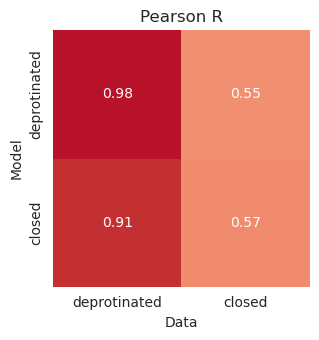

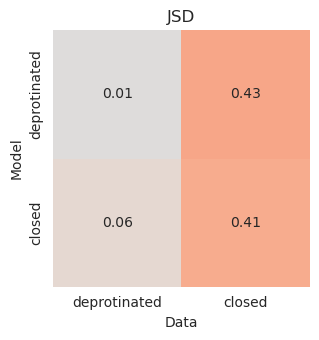

In [71]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_boxplot(deprot_model_deprot_data, deprot_model_closed_data, closed_model_deprot_data, closed_model_closed_data, title, save_filepath):
        
    # Create a sample 2x2 correlation matrix
    corr_matrix = np.array([
        [deprot_model_deprot_data, deprot_model_closed_data],
        [closed_model_deprot_data, closed_model_closed_data]
    ])

    # Create figure and axis
    plt.figure(figsize=(3.5, 3.5))

    # Create heatmap
    sns.heatmap(corr_matrix, 
                annot=True,  # Show numbers in cells
                cmap='coolwarm',  # Blue-red diverging colormap
                cbar=False,
                vmin=-1, vmax=1,  # Fix the range from -1 to 1
                center=0,  # Center the colormap at 0
                square=True,  # Make the cells square
                fmt='.2f',  # Show 2 decimal places
                xticklabels=['deprotinated', 'closed'],  # X-axis tick labels
                yticklabels=['deprotinated', 'closed'])  # Y-axis tick labels

    # Add axis labels
    plt.xlabel('Data')
    plt.ylabel('Model')

    plt.title(title)
    plt.tight_layout()

    # Adjust layout to prevent label cutoff
    plt.savefig(save_filepath, dpi=330)
    

    # Show the plot
    plt.show()

create_boxplot(deprot_model_deprot_data_corr_mean, deprot_model_closed_data_corr_mean, closed_model_deprot_data_corr_mean, closed_model_closed_data_corr_mean, 'Pearson R', save_filepath='ablation_figures/closed_deprotinated_bias_corr_matrix.png')
create_boxplot(deprot_model_deprot_data_jsd_mean, deprot_model_closed_data_jsd_mean, closed_model_deprot_data_jsd_mean, closed_model_closed_data_jsd_mean, 'JSD', save_filepath='ablation_figures/closed_deprotinated_bias_jsd_matrix.png')

## Correlation of performance of two models on immgen test data

In [7]:
def get_imgen_profile_preds(data_config, model, model_dir, saved_file_name):
    eval_set = 'testing'
    n_celltypes = 1
    bin_size = 1
    ocr_start = 0
    ocr_end = 250
    get_scalar_prediction, get_profile_prediction, get_scalar_observed, get_profile_observed = True, True, False, False
    seq_len = 250

    train_loader, val_loader, test_loader = load_data(data_config, batch_size=100)
    
    scalar_obs, scalar_pred, profile_obs, profile_pred = get_predictions(model, train_loader, val_loader, test_loader, 
                    n_celltypes, 
                    get_scalar_prediction, get_profile_prediction,
                    get_scalar_observed, get_profile_observed,
                    eval_set,
                    bin_size,
                    model_dir,
                    saved_file_name = saved_file_name, 
                    batch_size=100, 
                    save_pred=True,
                    ocr_start=ocr_start, ocr_end=ocr_end,
                    seq_len=seq_len)
    return profile_pred, profile_obs

In [8]:
import os
info_file = 

# pred of deprot model on immgen test data
deprot_model_imgen_profile_pred, imgen_obs  = get_imgen_profile_preds(info_file, deprot_model, os.path.dirname(deprot_model_path), saved_file_name='predictions_on_immgen_test_complete_bias_BP105_L0_1_corrected_normalized_11.3.24.npz')
closed_model_imgen_profile_pred, imgen_obs  = get_imgen_profile_preds(info_file, closed_model, os.path.dirname(closed_model_path), saved_file_name='predictions_on_immgen_test_complete_bias_BP105_L0_1_corrected_normalized_11.3.24.npz')

USING testing data loader
batch num 0
bias shape before it goes into model torch.Size([100, 250])
out shape profile, scalar torch.Size([100, 1, 250]) torch.Size([100, 1])
batch num 1
bias shape before it goes into model torch.Size([100, 250])
out shape profile, scalar torch.Size([100, 1, 250]) torch.Size([100, 1])
batch num 2
bias shape before it goes into model torch.Size([100, 250])
out shape profile, scalar torch.Size([100, 1, 250]) torch.Size([100, 1])
batch num 3
bias shape before it goes into model torch.Size([100, 250])
out shape profile, scalar torch.Size([100, 1, 250]) torch.Size([100, 1])
batch num 4
bias shape before it goes into model torch.Size([100, 250])
out shape profile, scalar torch.Size([100, 1, 250]) torch.Size([100, 1])
batch num 5
bias shape before it goes into model torch.Size([100, 250])
out shape profile, scalar torch.Size([100, 1, 250]) torch.Size([100, 1])
batch num 6
bias shape before it goes into model torch.Size([100, 250])
out shape profile, scalar torch.

In [62]:
deprot_model_imgen_profile_pred.shape

(32361, 1, 250)

In [81]:
# ACCOUNT FOR OFF-BY-TWO!
# check corr with pred and observed 
from utils import load_observed

# Get correlation between deprot model and closed model predictions
models_corr, models_jsd = get_correlation_and_JSD(deprot_model_imgen_profile_pred[:, :, :], closed_model_imgen_profile_pred[:, :, :], reduction=None)
print(np.mean(models_corr), np.mean(models_jsd))

bp_counts = load_observed(info_file, dataset_type='test', data_name='bp_counts')
bp_counts_avg_celltype = np.mean(bp_counts, axis=1, keepdims=True)


0.43637905 0.41335344
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_bias_BP105_L0_1_corrected_normalized_11.3.24/memmap/test.bp_counts.dat


In [83]:
obs_start_idx = 375
obs_end_idx = 625
bp_counts_avg_celltype.shape
deprot_obs_corr, deprot_obs_jsd = get_correlation_and_JSD(deprot_model_imgen_profile_pred[:, :, :], bp_counts_avg_celltype[:, :, obs_start_idx:obs_end_idx], reduction='mean') # with correction 
print(deprot_obs_corr, deprot_obs_jsd)

closed_obs_corr, closed_obs_jsd = get_correlation_and_JSD(closed_model_imgen_profile_pred[:, :, :], bp_counts_avg_celltype[:, :, obs_start_idx:obs_end_idx], reduction='mean')
print(closed_obs_corr, closed_obs_jsd)



0.44355336 0.42032072
0.7318165 0.2867481


In [86]:
deprot_model_closed_model_closed_data_corr, deprot_model_closed_model_closed_data_jsd = get_correlation_and_JSD(deprot_closed_profile_pred[:, :, 2:], closed_closed_profile_pred[:, :, :-2], reduction=None)
print(deprot_model_closed_model_closed_data_corr, deprot_model_closed_model_closed_data_jsd)


[0.9371897  0.9496636  0.94051373 ... 0.94382006 0.9382644  0.87862206] [0.06017029 0.04374722 0.06904597 ... 0.0714162  0.06516258 0.06027513]


file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_bias_BP105_L0_1_corrected_normalized_11.3.24/memmap/test.bp_counts.dat
(32361, 1, 250)


<Figure size 640x480 with 0 Axes>

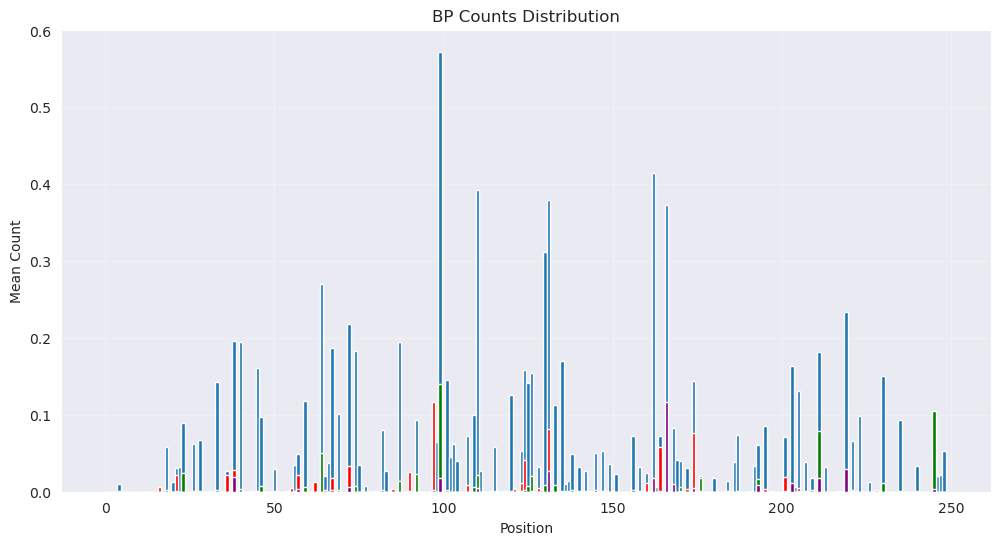

In [70]:
#
from utils import load_observed

bp_counts = load_observed(info_file, dataset_type='test', data_name='bp_counts')
print(deprot_model_imgen_profile_pred.shape)

deprot_model_imgen_profile_pred_corrected = deprot_model_imgen_profile_pred[:, :, 2:]

# Get the original shape
original_shape = deprot_model_imgen_profile_pred.shape

# Create zero-padded array with same shape as original
padded = np.zeros_like(deprot_model_imgen_profile_pred)

# Copy the sliced data into the padded array (it will automatically align from the start)
padded[:, :, :deprot_model_imgen_profile_pred_corrected.shape[2]] = deprot_model_imgen_profile_pred_corrected

# Now padded has the same shape as deprot_model_imgen_profile_pred but with zeros at the end
deprot_model_imgen_profile_pred_corrected = padded


index = 2000
data = np.mean(bp_counts[index, :, 375:625], axis=0)

plt.clf()
plt.figure(figsize=(12, 6))

# Plot base data
plt.bar(range(len(data)), data, width=1.0)

# Get the red and green data
red_data = deprot_model_imgen_profile_pred_corrected[index, 0, :]
green_data = closed_model_imgen_profile_pred[index, 0, :]

# Calculate overlap
overlap = np.minimum(red_data, green_data)

# Plot non-overlapping parts of red and green
plt.bar(range(len(data)), red_data - overlap, width=1.0, color='red')
plt.bar(range(len(data)), green_data - overlap, width=1.0, color='green')

# Plot overlap in purple
plt.bar(range(len(data)), overlap, width=1.0, color='purple')

plt.title('BP Counts Distribution')
plt.xlabel('Position')
plt.ylabel('Mean Count')
plt.grid(True, alpha=0.3)
plt.show()


# plt.plot(np.mean(bp_counts[index, :, 375:625], axis=0))

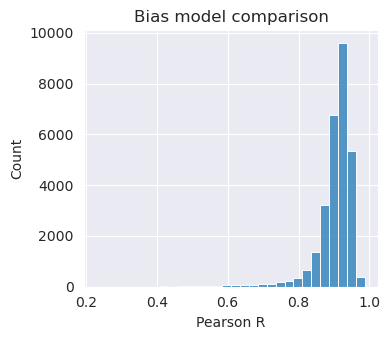

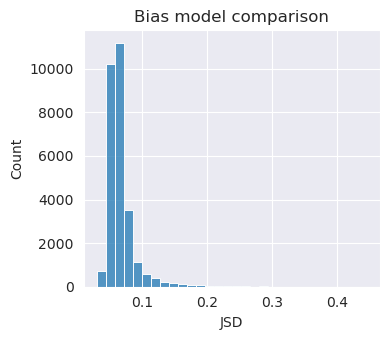

In [96]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(data, x_label, title, save_filename):
    # Create the histogram using seaborn
    plt.figure(figsize=(4, 3.5))
    sns.histplot(data=data, bins=30)  # kde=True adds a density curve

    # Customize the plot
    plt.xlabel(x_label)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_filename, dpi=300)

    # Display the plot
    plt.show()


plot_distribution(deprot_model_closed_model_closed_data_corr, 'Pearson R', 'Bias model comparison', 'ablation_figures/deprot_model_closed_model_closed_data_corr.png')
plot_distribution(deprot_model_closed_model_closed_data_jsd, 'JSD', 'Bias model comparison', 'ablation_figures/deprot_model_closed_model_closed_data_jsd.png')

In [19]:
print(np.mean(models_corr))

0.43637905
